# FINM 33150: Quantitative Trading Strategies Homework 5, Carry Trade
#### Author: Joshua Weekes
#### Due Date: 2/15/2024

#### Sections:

1. Introduction

2. Package Imports

3. Helper Functions

4. Data Import

5. Process Data and Calculate Metrics

6. Trading Algorithm Logic

7. Results

8. Analysis

9. Conclusion

# Introduction

The purpose of this notebook is to become familiar with a simple carry trade strategy. I will be calculating the bond price in a risky currency from the spot cureve in that country and then taking out a loan in British pounds to buy bonds in that risky currency and after a week I will close the bond position and pay back the loan. I will be entreing into the position only when the 5Y yield in the risky country is greater than the rate I am borrowing at + 50Bps. After I will calculate performance metrics of the trading strategies and their correlation and give the results of the total capital over time and profit and loss over time and per week. I will keep the position of the bond to be 10MM USD when opening to maintain 5x leverage with the loan.

# Package Imports

In [1]:
import os
import io
import pandas as pd
import numpy as np
import quandl
from matplotlib import pyplot as plt
from matplotlib import dates
import seaborn as sns
import statsmodels.api as sm
from datetime import date
import datetime
import functools
import random
import requests
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

us_business_day = CustomBusinessDay(calendar=USFederalHolidayCalendar())

global api_key
api_key = 'ykKjRrdMDZk8sVyrhPEV'
start_date_str = '2016-01-01'
end_date_str = '2023-06-30'
start_date = datetime.datetime.strptime(start_date_str, '%Y-%m-%d')
end_date = datetime.datetime.strptime(end_date_str, '%Y-%m-%d')

# Helper Functions

In [221]:
def grab_quandl_table(
    table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(r'C:\Users\joshw\OneDrive\Desktop\UChicago\FINM_33150_quantitative_trading_strategies\data', 'quandl_data_table_downloads')
    data_symlink = os.path.join(root_data_dir, f"{table_path}.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink
    
    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key=api_key, **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"

def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )


def compute_zcb_curve(spot_rates_curve):
    zcb_rates = spot_rates_curve.copy()
    for curve in spot_rates_curve.columns:
        spot = spot_rates_curve[curve]
        for tenor, spot_rate in spot.iteritems():
            if tenor>0.001:
                times = np.arange(tenor-0.5, 0, step=-0.5)[::-1]
                coupon_half_yr = 0.5*spot_rate
                z = np.interp(times, zcb_rates[curve].index.values, zcb_rates[curve].values) # Linear interpolation
                preceding_coupons_val = (coupon_half_yr*np.exp(-z*times)).sum()
                zcb_rates[curve][tenor] = -np.log((1-preceding_coupons_val)/(1+coupon_half_yr))/tenor
    return zcb_rates

def bond_price(zcb, coupon_rate, tenor):
    times = np.arange(tenor, 0, step=-0.5)[::-1]
    if times.shape[0]==0:
        p = 1.0
    else:
        r = np.interp(times, zcb.index.values, zcb.values) # Linear interpolation
        p = np.exp(-tenor*r[-1]) + 0.5 * coupon_rate * np.exp(-r*times).sum()
    return p

def spot_rate(zcb, tenor):
    times = np.arange(tenor, 0, step=-0.5)[::-1]
    if times.shape[0]==0:
        sr = None
    else:
        r = np.interp(times, zcb.index.values, zcb.values) # Linear interpolation
        coupons_pv_x = 0.5*np.exp(-r*times).sum()
        final_pv = np.exp(-tenor*r[-1])
        sr = (1.0 - final_pv) / coupons_pv_x # Solves x + c * delta = 1.0
    return sr

def compute_spot_rates(zcb_rates):
    spot = zcb_rates.copy()
    for curve in zcb_rates.columns:
        zcb = zcb_rates[curve]
        for tenor, rate in zcb.iteritems():
            if tenor>0.001:
                spot[curve][tenor] = spot_rate(zcb, tenor)
    return spot

def join_dataframes(df):
    # Pivot the dataframe to have unique 'code' values as columns and 'date' as the index
    pivot_df = df.pivot_table(index='date', columns='code', values='rate')
    
    # Rename the columns as specified
    pivot_df.columns = [f'USD_{code}_rate' for code in pivot_df.columns]
    
    # Reset the index to make 'date' a column again, if needed for further processing
    pivot_df.reset_index(inplace=True)
    
    # Interpolate missing values using the 'time' method
    # First, ensure 'date' is of datetime type for effective interpolation
    pivot_df['date'] = pd.to_datetime(pivot_df['date'])
    pivot_df = pivot_df.set_index('date').interpolate(method='time').reset_index()
    
    return pivot_df

def join_yield_dataframes(df):
    # Drop the 'Unnamed:0' column
    df = df.drop(columns=['Unnamed: 0'])
    
    # Pivot the dataframe to have 'tenor' values as new columns with '{tenor}_yield' format
    # Keeping 'date' and 'shortname' as columns to ensure data uniqueness
    df_pivoted = df.pivot_table(index=['date', 'shortname'], columns='tenor', values='yield', aggfunc='first')
    
    # Rename columns to '{tenor}_yield'
    df_pivoted.columns = [f'{tenor}_yield' for tenor in df_pivoted.columns]
    
    # Reset index to turn 'date' and 'shortname' back into regular columns, not the index
    df_pivoted.reset_index(inplace=True)
    
    # Convert 'date' to datetime format if not already
    df_pivoted['date'] = pd.to_datetime(df_pivoted['date'])

    return df_pivoted

def compute_zcb_curve(yield_df):
    # Define the tenors based on your available columns in 'yield_df'
    tenor_columns = ['6M_yield', '1Y_yield', '5Y_yield', '10Y_yield']
    tenors = [.5, 1.0, 5.0, 10.0]  # Corresponding tenors in years
    
    # Initialize a DataFrame to store the ZCB rates
    zcb_df = yield_df.copy()
    
    # Add columns for ZCB rates
    for tenor in tenor_columns:
        zcb_df[tenor.replace('_yield', '_ZCB')] = np.nan
    
    # Calculate ZCB rates
    for index, row in yield_df.iterrows():
        for tenor_col, tenor in zip(tenor_columns, tenors):
            spot_rate = row[tenor_col]
            
            if tenor > 0.001:  # Assuming calculations for tenors longer than 6 months
                times = np.arange(tenor - 0.5, 0, step=-0.5)[::-1]
                coupon_half_yr = 0.5 * spot_rate

                z = np.interp(times, tenors, [row[col] for col in tenor_columns])
                
                preceding_coupons_val = (coupon_half_yr * np.exp(-z * times)).sum()
                zcb_rate = -np.log((1 - preceding_coupons_val) / (1 + coupon_half_yr)) / tenor
            
            # Update the ZCB rate in the new DataFrame
            zcb_col_name = tenor_col.replace('_yield', '_ZCB')
            zcb_df.at[index, zcb_col_name] = zcb_rate
    
    return zcb_df

def price_5y_bond_from_zcb_df(zcb_df):
    """
    Calculates the price of a 5-year tenor bond using the ZCB curve and the 5Y_yield as the coupon rate.
    This function only requires the zcb_df which includes both spot rates and calculated ZCB rates.
    """
    
    bond_prices = pd.DataFrame(index=zcb_df.index, columns=['date', 'shortname', '5Y_bond_price'])
    bond_prices['date'] = zcb_df['date']
    bond_prices['shortname'] = zcb_df['shortname']
    
    for index, row in zcb_df.iterrows():
        coupon_rate = row['5Y_yield']
        
        # Define tenor values for interpolation and the corresponding ZCB values
        tenor_values = [0.5, 1.0, 5.0, 10.0]
        zcb_values = [row['6M_ZCB'], row['1Y_ZCB'], row['5Y_ZCB'], row['10Y_ZCB']]
        
        times = np.arange(5, 0, step=-0.5)[::-1]
        if times.shape[0] == 0:
            p = 1.0
        else:
            # Implementing the pseudocode for bond price calculation
            r = np.interp(times, tenor_values, zcb_values)  # Linear interpolation for discount rates
            p = np.exp(-5 * r[-1]) + 0.5 * coupon_rate * np.exp(-r * times).sum()
        
        bond_prices.at[index, '5Y_bond_price'] = p
        bond_prices.at[index, '5Y_yield'] = row['5Y_yield']
        bond_prices.at[index, '6M_ZCB'] = row['6M_ZCB']
        bond_prices.at[index, '1Y_ZCB'] = row['1Y_ZCB']
        bond_prices.at[index, '5Y_ZCB'] = row['5Y_ZCB']
        bond_prices.at[index, '10Y_ZCB'] = row['10Y_ZCB']
    
    return bond_prices

def ensure_wednesdays_with_interpolation(df):
    """
    Reindexes the DataFrame to ensure every Wednesday between the start and end dates is included
    and interpolates missing values for these Wednesdays.
    
    Parameters:
    - df: DataFrame with a DatetimeIndex.
    
    Returns:
    - DataFrame reindexed to include all Wednesdays with interpolated values for missing dates.
    """

    df.index = df['date']
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    df.rename(columns={'IUDSOIA': 'OIS_rate'}, inplace=True)
    df['indicator_OIS_rate'] = (df['OIS_rate'] + 1.0) / 100
    df['OIS_rate'] = (df['OIS_rate'] + 0.5) / 100
    df['OIS_rate'] = (1 + df['OIS_rate']) ** (1/52) - 1

    # Ensure the index is a DatetimeIndex
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame index must be a DatetimeIndex.")
    
    # Generate a date range that includes all Wednesdays between the start and end of the original index
    start_date = df.index.min()
    end_date = df.index.max()
    all_wednesdays = pd.date_range(start=start_date, end=end_date, freq='W-WED')
    
    # Reindex the DataFrame to include the new date range, filling missing entries with NaN
    df_reindexed = df.reindex(all_wednesdays)
    df_reindexed.drop(columns=['date', 'shortname'], inplace=True)

    df_reindexed['5Y_bond_price'] = df_reindexed['5Y_bond_price'].astype(np.float64)
    
    # Interpolate missing values. The default method is 'linear', but you can specify other methods.
    # numeric_cols = df.select_dtypes(include=['number']).columns
    
    # Apply interpolation to numeric columns only
    df_reindexed = df_reindexed.interpolate(method='time')
    
    return df_reindexed

# Import Data

In [17]:
curr_codes = ['GBP', 'EGP', 'HUF', 'CRC', 'RON']
fx_df = fetch_quandl_table('EDI/CUR', avoid_download=True, code=curr_codes)
fx_df = join_dataframes(fx_df)
fx_df = fx_df.set_index('date')
fx_df.head()

Data file C:\Users\joshw\OneDrive\Desktop\UChicago\FINM_33150_quantitative_trading_strategies\data\quandl_data_table_downloads\EDI/CUR_20240214.zip size 261211 exists already, no need to download


,USD_CRC_rate,USD_EGP_rate,USD_GBP_rate,USD_HUF_rate,USD_RON_rate
date,,,,,
2000-01-01,NaN,NaN,0.618877,251.766863,NaN
2000-01-02,NaN,NaN,0.618877,251.766863,NaN
2000-01-03,NaN,NaN,0.614647,251.694743,1.811607
2000-01-04,NaN,NaN,0.610927,247.740170,1.831651
2000-01-05,NaN,NaN,0.609433,246.607345,1.834029


In [99]:
# Define the URL endpoint and parameters for the request
url_endpoint = 'https://www.bankofengland.co.uk/boeapps/database/_iadb-fromshowcolumns.asp?csv.x=yes'
payload = { 
    'Datefrom': '01/Jan/2001',  # Adjust the start date as needed
    'Dateto': 'now',            # Use 'now' for the current date or specify an end date
    'SeriesCodes': 'IUDSOIA',   # The series code you're interested in
    'CSVF': 'TN',               # Format: Tabular no titles
    'UsingCodes': 'Y',          # Indicates that series codes are used in the request
    'VPD': 'Y',                 # Include provisional data if desired ('Y' or 'N')
    'VFD': 'N'                  # Include footnotes ('Y' or 'N')
}


# Optional: Define headers to mimic a browser request (helps avoid potential HTTP errors)
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}


# Send the GET request
response = requests.get(url_endpoint, params=payload, headers=headers)


# Initialize an empty DataFrame in case of an unsuccessful request
ois_rate_df = pd.DataFrame()


# Check if the response was successful (HTTP status code 200)
if response.status_code == 200:
   
    # Use Pandas to read the CSV data from the response
    ois_rate_df = pd.read_csv(io.StringIO(response.text))
else:
    print("Failed to retrieve data: HTTP status code", response.status_code)

ois_rate_df = ois_rate_df.rename(columns={'DATE': 'date'})
ois_rate_df['date'] = pd.to_datetime(ois_rate_df['date'], format='mixed')
ois_rate_df = ois_rate_df.set_index('date')

display(ois_rate_df['2010-01-06':'2010-01-12'])

# print(plot_swap_rates_gbp_with_ggplot(ois_rate_df))

# print(plot_fx_rates_with_ggplot_v3(FX_data, 'GBP'))

,IUDSOIA
date,
2010-01-06,0.4534
2010-01-07,0.4541
2010-01-08,0.4546
2010-01-11,0.4523
2010-01-12,0.4490


In [35]:
desired_countries = ['Arab Rep Egypt', 'Hungary', 'Rep Costa Rica', 'Romania']

yield_curve_df = pd.read_csv(r'data/InferredYieldCurves_2024.tab', sep='\t')
yield_curve_df = yield_curve_df[yield_curve_df['shortname'].isin(desired_countries)]
yield_curve_df = join_yield_dataframes(yield_curve_df)
yield_curve_df.head()

,date,shortname,10Y_yield,1Y_yield,5Y_yield,6M_yield
0,2010-01-04,Arab Rep Egypt,0.075885,0.028901,0.061109,0.023642
1,2010-01-04,Rep Costa Rica,0.060319,0.012753,0.045461,0.011485
2,2010-01-04,Romania,0.077191,0.037587,0.064773,0.033161
3,2010-01-05,Arab Rep Egypt,0.074642,0.027466,0.059096,0.023556
4,2010-01-05,Rep Costa Rica,0.060947,0.012151,0.044628,0.007155


# Data Processing and Calculating Metrics

In [219]:
zcb_rate_df = compute_zcb_curve(yield_curve_df)
# zcb_rate_df.head(10)

In [218]:
bond_prices_df = price_5y_bond_from_zcb_df(zcb_rate_df)
# bond_prices_df.head()

In [92]:
egp_fx_df = fx_df.loc[:, ['USD_GBP_rate', 'USD_EGP_rate']]
crc_fx_df = fx_df.loc[:, ['USD_GBP_rate', 'USD_CRC_rate']]
huf_fx_df = fx_df.loc[:, ['USD_GBP_rate', 'USD_HUF_rate']]
ron_fx_df = fx_df.loc[:, ['USD_GBP_rate', 'USD_RON_rate']]

In [220]:
egypt_bond_prices = bond_prices_df[bond_prices_df['shortname'] == 'Arab Rep Egypt'].reset_index(drop=True)
egypt_bond_prices = egypt_bond_prices.merge(egp_fx_df, left_on='date', right_index=True)
egypt_bond_prices = egypt_bond_prices.merge(ois_rate_df, left_on='date', right_index=True)
egypt_bond_prices = ensure_wednesdays_with_interpolation(egypt_bond_prices)

costa_rica_bond_prices = bond_prices_df[bond_prices_df['shortname'] == 'Rep Costa Rica'].reset_index(drop=True)
costa_rica_bond_prices = costa_rica_bond_prices.merge(crc_fx_df, left_on='date', right_index=True)
costa_rica_bond_prices = costa_rica_bond_prices.merge(ois_rate_df, left_on='date', right_index=True)
costa_rica_bond_prices = ensure_wednesdays_with_interpolation(costa_rica_bond_prices)

hungary_bond_prices = bond_prices_df[bond_prices_df['shortname'] == 'Hungary'].reset_index(drop=True)
hungary_bond_prices = hungary_bond_prices.merge(huf_fx_df, left_on='date', right_index=True)
hungary_bond_prices = hungary_bond_prices.merge(ois_rate_df, left_on='date', right_index=True)
hungary_bond_prices = ensure_wednesdays_with_interpolation(hungary_bond_prices)

romania_bond_prices = bond_prices_df[bond_prices_df['shortname'] == 'Romania'].reset_index(drop=True)
romania_bond_prices = romania_bond_prices.merge(ron_fx_df, left_on='date', right_index=True)
romania_bond_prices = romania_bond_prices.merge(ois_rate_df, left_on='date', right_index=True)
romania_bond_prices = ensure_wednesdays_with_interpolation(romania_bond_prices)

# display(egypt_bond_prices)
# display(costa_rica_bond_prices)
# display(hungary_bond_prices)
# display(romania_bond_prices)

# Trading Algorithm Logic

In [183]:
class Action(Enum):
    Buy = 1
    Nothing = 2

class Strategy:
    def __init__(self, prices_df):
        self.prices_df = prices_df.copy()
        # self.prices_df['date'] = pd.to_datetime(self.prices_df['date'])
        # self.prices_df.set_index('date', inplace=True)
        self.position = 0
        self.position_value = 0
        self.position_pnl = 0
        self.num_trades = 0
        self.bonds_bought = 0
        self.fx_col = self.prices_df.columns[9]
        self.accrued_interest = 0
        self.coupon = 0
        self.borrow_rate = 0
        self.new_bond_price = 0
        self.weekly_pnl = 0
        self.action = Action.Nothing

    def open_position(self, row):
        risky_currency = 10e6 * row[self.fx_col]
        self.bonds_bought = risky_currency / row['5Y_bond_price']
        self.coupon = row['5Y_yield']
        self.borrow_rate = row['OIS_rate']
        self.position = 1
        self.position_value = 10e6
        self.position_pnl = 0
        self.num_trades += 1

    def close_position(self):
        self.position = 0
        self.position_value = 0
        self.position_pnl = 0
        self.bonds_bought = 0
        self.accrued_interest = 0

    def calculate_accrued_interest(self, row):
        value_in_gbp = 8e6 * row['USD_GBP_rate']
        self.accrued_interest = (value_in_gbp * self.borrow_rate) / row['USD_GBP_rate']

    def calculate_new_bond_price(self, row):
        zcb_rates = [row['6M_ZCB'], row['1Y_ZCB'], row['5Y_ZCB'], row['10Y_ZCB']]
        tenor = 5 - 1/52
        # Placeholder for bond pricing logic; you should replace this with actual calculations
        self.price_5y_bond_trading(self.coupon, zcb_rates, tenor)

        
    def price_5y_bond_trading(self, coupon, zcb_rates, tenor):
        # Define tenor values for interpolation and the corresponding ZCB values
        tenor_values = [0.5, 1.0, 5.0, 10.0]
        
        times = np.arange(tenor, 0, step=-0.5)[::-1]
        if times.shape[0] == 0:
            p = 1.0
        else:
            # Implementing the pseudocode for bond price calculation
            r = np.interp(times, tenor_values, zcb_rates)  # Linear interpolation for discount rates
            p = np.exp(-tenor * r[-1]) + 0.5 * coupon * np.exp(-r * times).sum()

        self.new_bond_price = p

    def calculate_pnl(self, row):
        self.calculate_new_bond_price(row)  # Ensure this is calculated first
        value_of_position = self.new_bond_price * self.bonds_bought / row[self.fx_col]
        value_of_position -= self.accrued_interest
        self.weekly_pnl = value_of_position - self.position_value

    def run(self):
        trade_summary = pd.DataFrame(index=self.prices_df.index,
                                     columns=['weekly PnL', 'cum PnL', 'bond pos size', 'action', 'position value', 'position PnL'],
                                     dtype=float)
        trade_summary.fillna(0, inplace=True)
        trade_summary['action'] = self.action

        cum_pnl = 0
        for date, row in self.prices_df.iterrows():
            self.action = Action.Nothing

            if self.position == 0 and row['5Y_yield'] > row['indicator_OIS_rate']:
                self.action = Action.Buy
                self.open_position(row)
            elif self.position == 1:
                self.calculate_accrued_interest(row)
                self.calculate_pnl(row)
                cum_pnl += self.weekly_pnl
                self.close_position()
                if row['5Y_yield'] > row['indicator_OIS_rate']:
                    self.action = Action.Buy
                    self.open_position(row)

            trade_summary.loc[date] = [self.weekly_pnl, cum_pnl, self.bonds_bought, self.action, self.position_value, self.new_bond_price]

        return trade_summary

In [222]:
egypt_strategy = Strategy(egypt_bond_prices)
egypt_trade_summary = egypt_strategy.run()
# display(egypt_trade_summary)

costa_rica_strategy = Strategy(costa_rica_bond_prices)
costa_rica_trade_summary = costa_rica_strategy.run()
# display(costa_rica_trade_summary)

hungary_strategy = Strategy(hungary_bond_prices)
hungary_trade_summary = hungary_strategy.run()
# display(hungary_trade_summary)

romania_strategy = Strategy(romania_bond_prices)
romania_trade_summary = romania_strategy.run()
# display(romania_trade_summary)

# Results

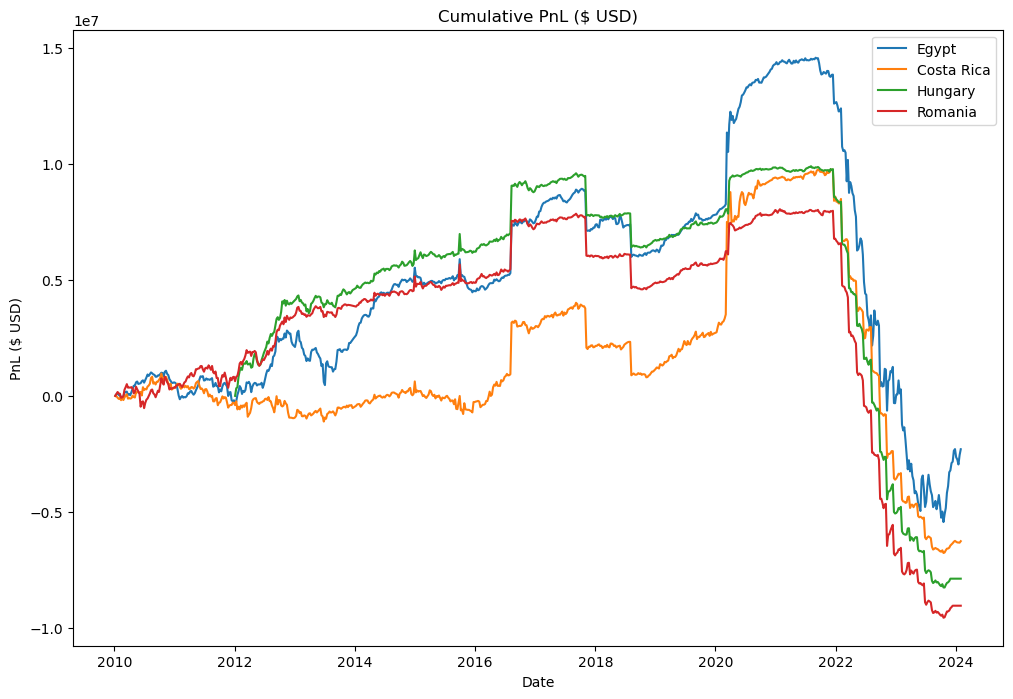

In [180]:
plt.figure(figsize=(12, 8))
plt.plot(egypt_trade_summary['cum PnL'], label='Egypt')
plt.plot(costa_rica_trade_summary['cum PnL'], label='Costa Rica')
plt.plot(hungary_trade_summary['cum PnL'], label='Hungary')
plt.plot(romania_trade_summary['cum PnL'], label='Romania')
plt.title('Cumulative PnL ($ USD)')
plt.xlabel('Date')
plt.ylabel('PnL ($ USD)')
plt.legend()

plt.show()

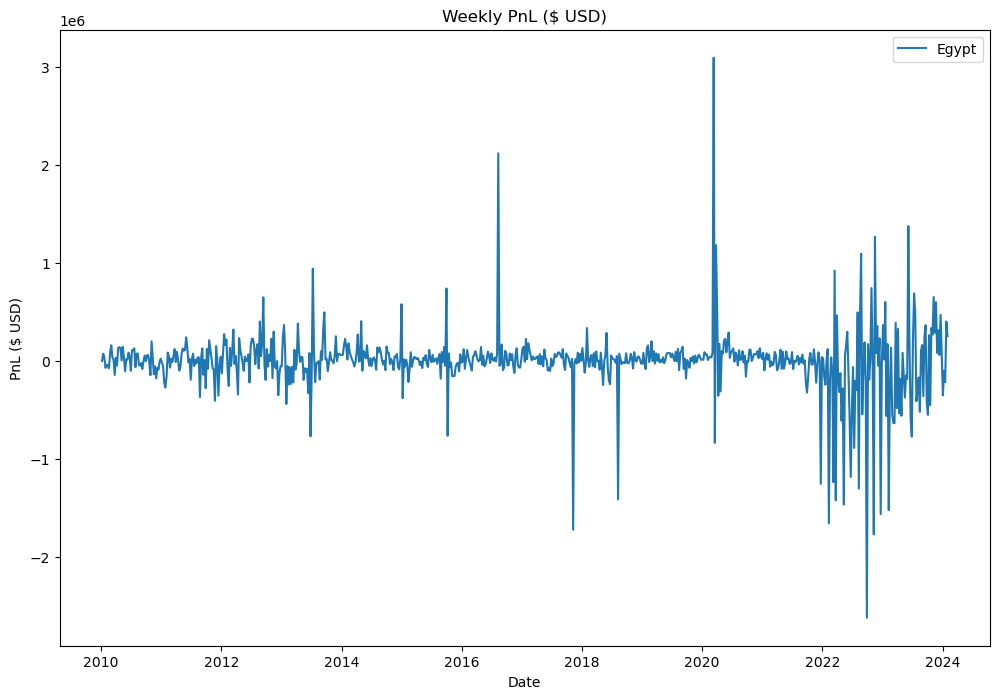

In [212]:
plt.figure(figsize=(12, 8))
plt.plot(egypt_trade_summary['weekly PnL'], label='Egypt')
# plt.plot(costa_rica_trade_summary['weekly PnL'], label='Costa Rica')
# plt.plot(hungary_trade_summary['weekly PnL'], label='Hungary')
# plt.plot(romania_trade_summary['weekly PnL'], label='Romania')
plt.title('Weekly PnL ($ USD)')
plt.xlabel('Date')
plt.ylabel('PnL ($ USD)')
plt.legend()

plt.show()

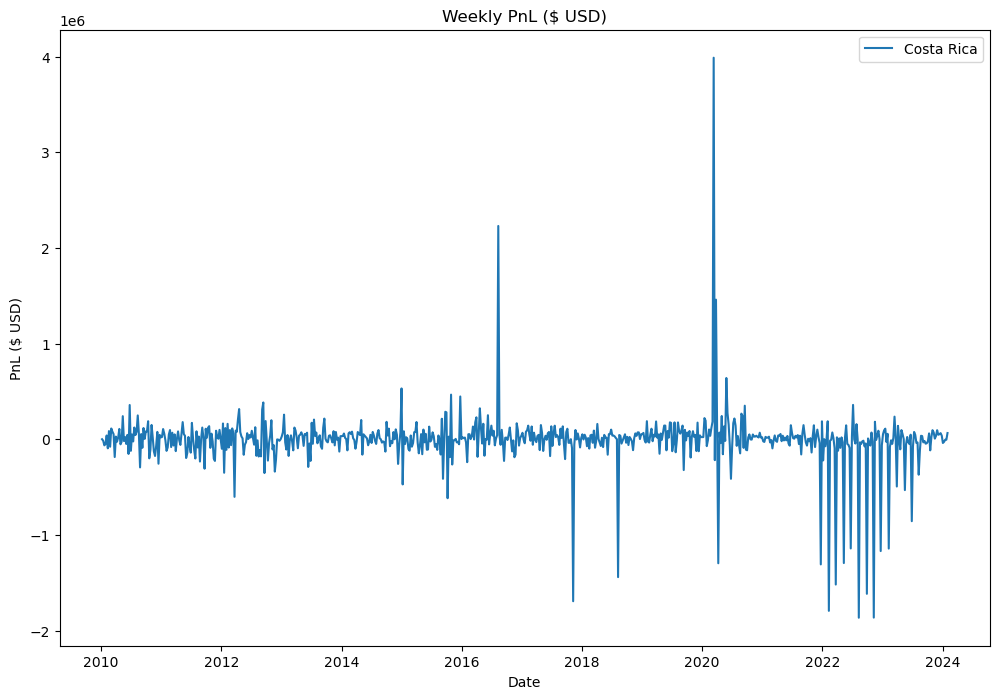

In [213]:
plt.figure(figsize=(12, 8))
# plt.plot(egypt_trade_summary['weekly PnL'], label='Egypt')
plt.plot(costa_rica_trade_summary['weekly PnL'], label='Costa Rica')
# plt.plot(hungary_trade_summary['weekly PnL'], label='Hungary')
# plt.plot(romania_trade_summary['weekly PnL'], label='Romania')
plt.title('Weekly PnL ($ USD)')
plt.xlabel('Date')
plt.ylabel('PnL ($ USD)')
plt.legend()

plt.show()

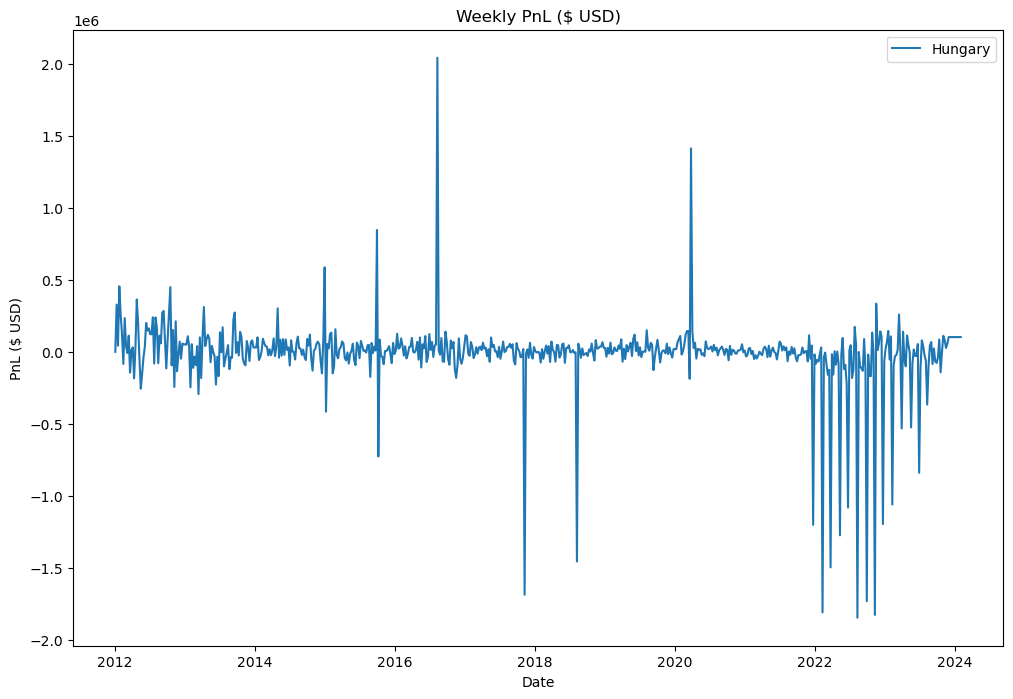

In [214]:
plt.figure(figsize=(12, 8))
# plt.plot(egypt_trade_summary['weekly PnL'], label='Egypt')
# plt.plot(costa_rica_trade_summary['weekly PnL'], label='Costa Rica')
plt.plot(hungary_trade_summary['weekly PnL'], label='Hungary')
# plt.plot(romania_trade_summary['weekly PnL'], label='Romania')
plt.title('Weekly PnL ($ USD)')
plt.xlabel('Date')
plt.ylabel('PnL ($ USD)')
plt.legend()

plt.show()

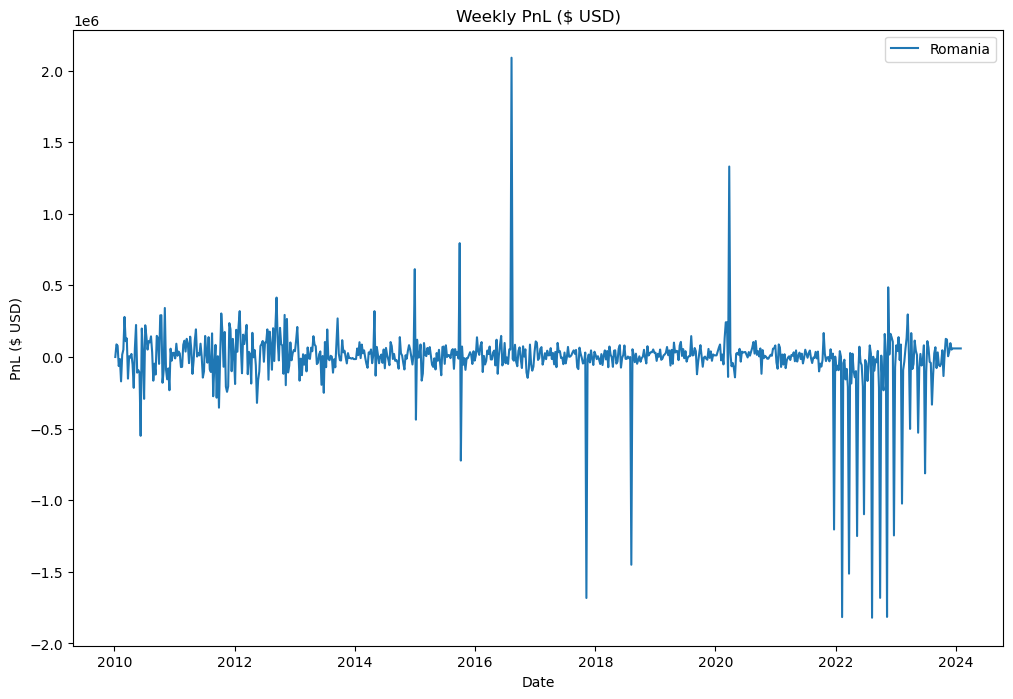

In [215]:
plt.figure(figsize=(12, 8))
# plt.plot(egypt_trade_summary['weekly PnL'], label='Egypt')
# plt.plot(costa_rica_trade_summary['weekly PnL'], label='Costa Rica')
# plt.plot(hungary_trade_summary['weekly PnL'], label='Hungary')
plt.plot(romania_trade_summary['weekly PnL'], label='Romania')
plt.title('Weekly PnL ($ USD)')
plt.xlabel('Date')
plt.ylabel('PnL ($ USD)')
plt.legend()

plt.show()

# Analysis

In [199]:
def performance_summary(return_data, annualization = 52):
    """ 
        Returns the Performance Stats for given set of returns
        Inputs: 
            return_data - DataFrame with Date index and Monthly Returns for different assets/strategies.
        Output:
            summary_stats - DataFrame with annualized mean return, vol, sharpe ratio. Skewness, Excess Kurtosis, Var (0.5) and
                            CVaR (0.5) and drawdown based on monthly returns. 
    """
    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x*annualization)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x*np.sqrt(annualization))
    summary_stats['Sharpe Ratio'] = summary_stats['Mean']/summary_stats['Volatility']

    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.05)'] = return_data.quantile(.05, axis = 0)
    summary_stats['CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis = 0)].mean()
    
    wealth_index = 1000*(1+return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date
    
    return summary_stats

In [200]:
perf_dict = {'Egyptian Bonds': egypt_trade_summary.iloc[1:, :], 
             'Costa Rican Bonds': costa_rica_trade_summary.iloc[1:, :],
             'Hungarian Bonds': hungary_trade_summary.iloc[1:, :], 
             'Romanian Bonds': romania_trade_summary.iloc[1:, :]}

In [201]:
carry_perf_summary = []
for placeholder, df in perf_dict.items():
    summary_df = performance_summary(df[['cum PnL']].pct_change())
    
    # Add a column or set the DataFrame's name to the key for identification
    summary_df['Foreign Bond Strategy'] = placeholder
    
    # Append the summary DataFrame to the list
    carry_perf_summary.append(summary_df)

carry_perf_summary = pd.concat(carry_perf_summary, axis=0)
carry_perf_summary.set_index('Foreign Bond Strategy', inplace=True)

carry_perf_summary

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recovery
Foreign Bond Strategy,,,,,,,,,,,
Egyptian Bonds,-3.423378,11.617933,-0.294663,-15.189402,323.949802,-0.279561,-2.813453,-1.985852,2010-01-20,2010-02-17,2010-03-03
Costa Rican Bonds,16.000219,50.223308,0.318582,16.621494,309.653727,-0.878568,-3.969512,-9.808002,2013-06-26,2021-12-08,2022-11-09
Hungarian Bonds,0.533410,0.984799,0.541643,10.853686,217.223857,-0.034054,-0.143879,-1.834329,2021-08-04,2023-10-25,NaT
Romanian Bonds,-4.562356,12.025364,-0.379394,-20.263677,446.698080,-0.207542,-2.318558,-2.188574,2021-01-27,2023-10-18,NaT


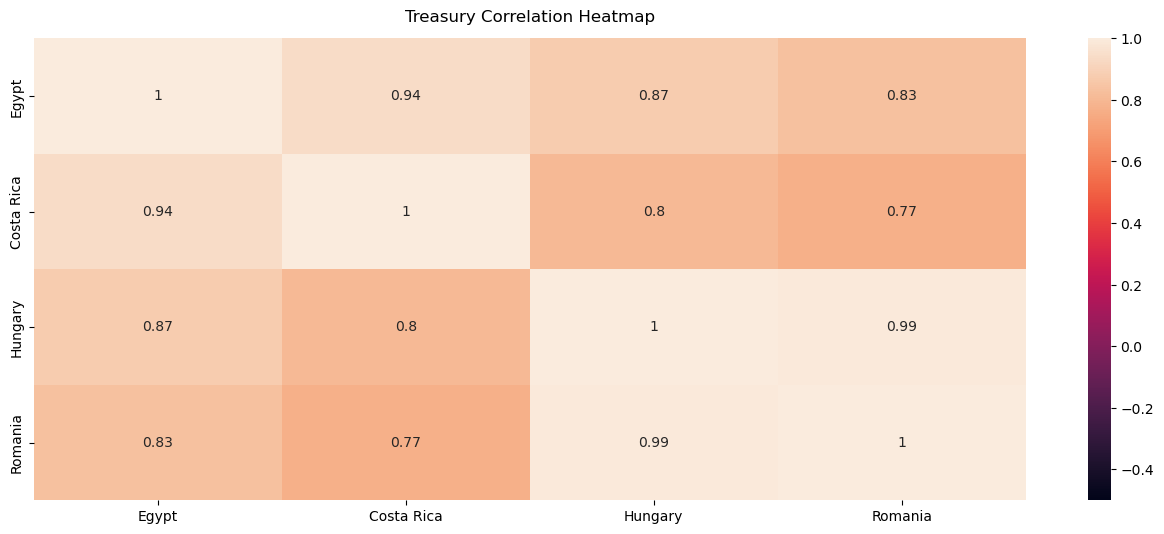

In [216]:
full = pd.concat([perf_dict['Egyptian Bonds'][['cum PnL']], perf_dict['Costa Rican Bonds'][['cum PnL']], perf_dict['Hungarian Bonds'][['cum PnL']], perf_dict['Romanian Bonds'][['cum PnL']]], axis=1)
full.columns = ['Egypt', 'Costa Rica', 'Hungary', 'Romania']
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(full.corr(), vmin=-0.5, vmax=1, annot=True)
heatmap.set_title('Treasury Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

# Conclusion

Overall the carry trading strategies were relatively successful until the rapid increase in OIS rate that started around 2022. From the statistics it seems as though Costa Rican Bonds performed the best in average returns and Hungarian Bonds had the highest sharpe. From the Return graphs the Egyptian Bonds had the highest cumulative returns but got crushed in the period of high interest rates. From the correlation of the returns I am surprised that there are correlations as low as .77 since I thought it was standard to see .95+ in bond markets but this may be from the fact that we are analyzing different risky countries. I think there may be something I am overlooking from a risk management point of view that allows me to get crushed so much at the end but I am not sure what is going wrong but I assume it is that while the rate of the 5Y yield in the risky currency is higher than the OIS rate the change in bond value is not quite reflecting this increase so as the OIS rate increases it pales in comparison to the accrued interest owed on the loan. I think it would be interesting to continue this project but have a weighting schema for investing in the different foreign markets to try and capitalize on the countries with the most attractive interest rates since the holding period is so short for this trade. I think it would also be interesting to try and model the rates with eachother with lags to see if there is any predictive performance.